In [ ]:
%%capture
!pip install pycbc
!pip install nnAudio

In [ ]:
import os
import json
import random
import collections

import torch
from nnAudio.Spectrogram import CQT1992v2, CQT2010v2

import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal

import pycbc
import pycbc.psd
import pylab
from pycbc.psd import welch, interpolate

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [235]:
1

1

In [ ]:
from pycbc import catalog
from pycbc.catalog import Merger
from pycbc.frame import query_and_read_frame
from pycbc.filter import resample_to_delta_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %%time
# !mkdir -p ./input/
# !unzip -q /content/drive/MyDrive/KaggleDataSet/G2Net/input/g2net-gravitational-wave-detection.zip -d ./input/

CPU times: user 14.7 s, sys: 2.32 s, total: 17 s
Wall time: 26min 53s


In [ ]:
# %%time
# !mkdir -p ./input/q-train/
# !tar -xf /content/drive/MyDrive/KaggleDataSet/G2Net/input/g2net-gravitational-wave-detection-whiten-qtransform-train.tar -C ./input/q-train/

CPU times: user 3.87 s, sys: 768 ms, total: 4.63 s
Wall time: 8min 58s


In [ ]:
# %%time
# !mkdir -p ./input/q-test/
# !tar -xf /content/drive/MyDrive/KaggleDataSet/G2Net/input/g2net-gravitational-wave-detection-whiten-qtransform-test.tar -C ./input/q-test/

In [ ]:
def get_train_file_path(image_id): ## !!
    return "{}/train/{}/{}/{}/{}.npy".format(data_folder,
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):  ## !!
    return "{}/test/{}/{}/{}/{}.npy".format(data_folder,
        image_id[0], image_id[1], image_id[2], image_id)


data_folder = './drive/MyDrive/KaggleDataSet/G2Net/input/g2net-gravitational-wave-detection' ## !!

In [ ]:
train = pd.read_csv(f'{data_folder}/training_labels.csv')
test = pd.read_csv(f'{data_folder}/sample_submission.csv')
pred_path = './drive/MyDrive/KaggleDataSet/G2Net-Model/G2Net-Model-Vincent/noResize-PL/train_df_preds.csv'
pred_df = pd.read_csv(pred_path)
train = pd.merge(train, pred_df[["id","preds"]], how="left",on="id")

#train['old_q_tran'] = train['id'].apply(lambda x: f"./input/q-train/{x}.npy")

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train["fold"] = -1
for fold, (train_index, valid_index) in enumerate(skf.split(train, train["target"])):
    train.loc[valid_index,"fold"] = fold

display(train.head())
display(test.head())

id  target  ...                                          file_path fold
0  00000e74ad       1  ...  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...    2
1  00001f4945       0  ...  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...    1
2  0000661522       0  ...  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...    3
3  00007a006a       0  ...  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...    3
4  0000a38978       1  ...  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...    4

[5 rows x 5 columns]

id  target                                          file_path
0  00005bced6     0.5  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...
1  0000806717     0.5  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...
2  0000ef4fe1     0.5  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...
3  00020de251     0.5  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...
4  00024887b5     0.5  ./drive/MyDrive/KaggleDataSet/G2Net/input/g2ne...

In [ ]:
debugging_mode = False
if debugging_mode:
    train = train.iloc[:1000,:]
    test = train.iloc[:1000,:]

# Image Creation Function

In [ ]:
idx = '098a464da9'
path = train.query(f"id=='{idx}' ")['file_path'].iloc[0]
target = train.query(f"id=='{idx}' ")['target'].iloc[0]
waves = np.load(path)
tss = []
for wave in waves:
  ts = pycbc.types.TimeSeries(wave, epoch=0, delta_t=1.0/2048)
  tss.append(ts)

In [ ]:
wave_pycbc = tss[0]
wave_pycbc

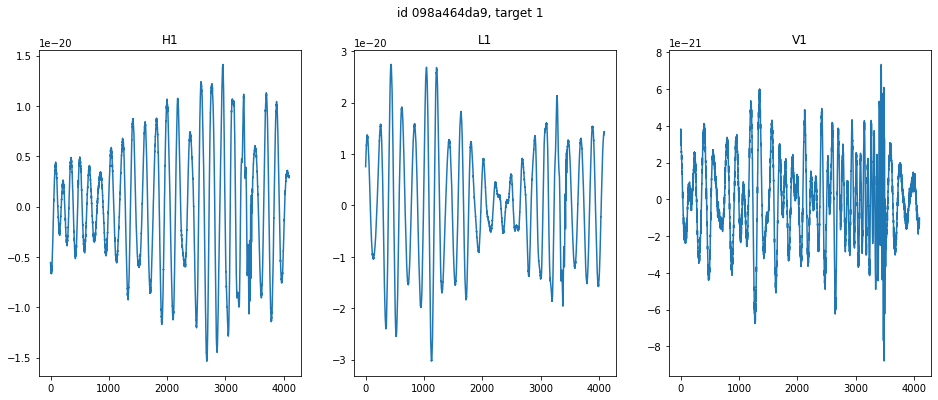

In [ ]:
fig = plt.figure(figsize=(16,6))
signals = ["H1","L1","V1"]
for i, ts in enumerate(tss):
    plt.subplot(1,3,i+1)
    plt.plot(ts)
    plt.title(signals[i])
plt.suptitle(f"id {idx}, target {target}")
plt.show()

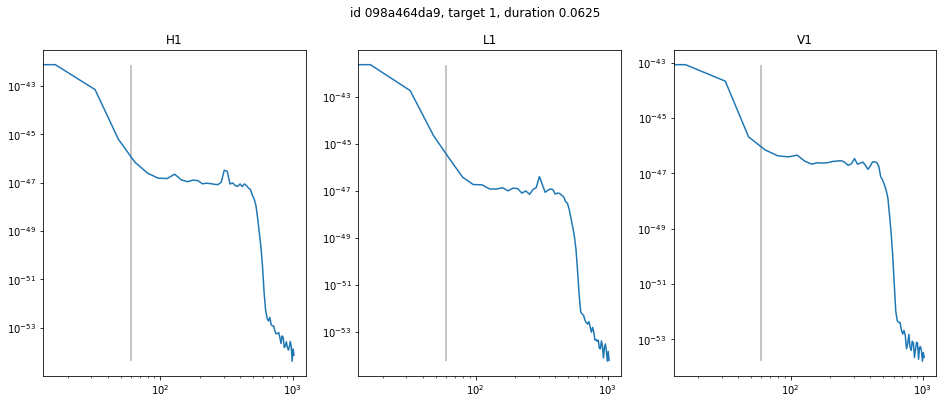

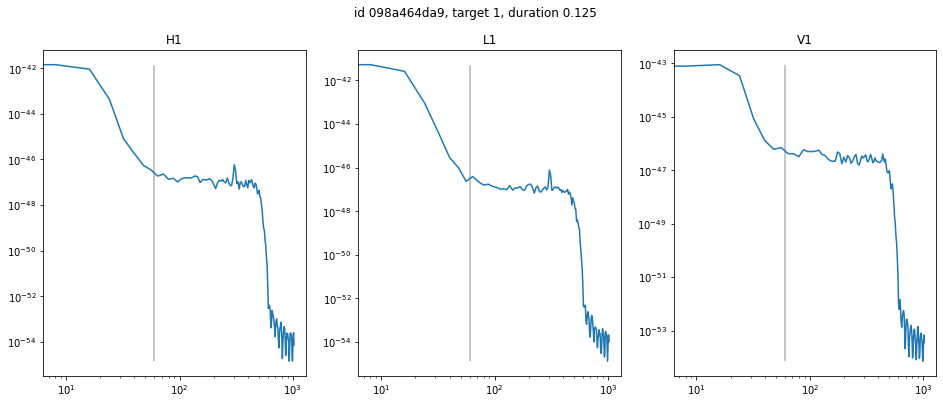

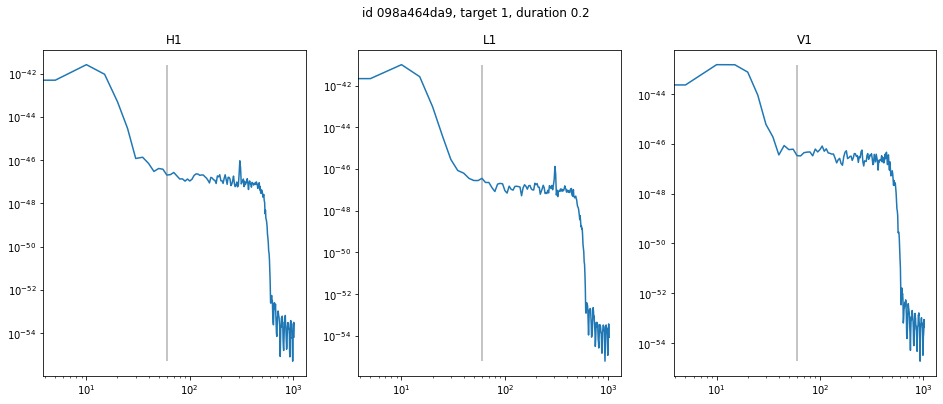

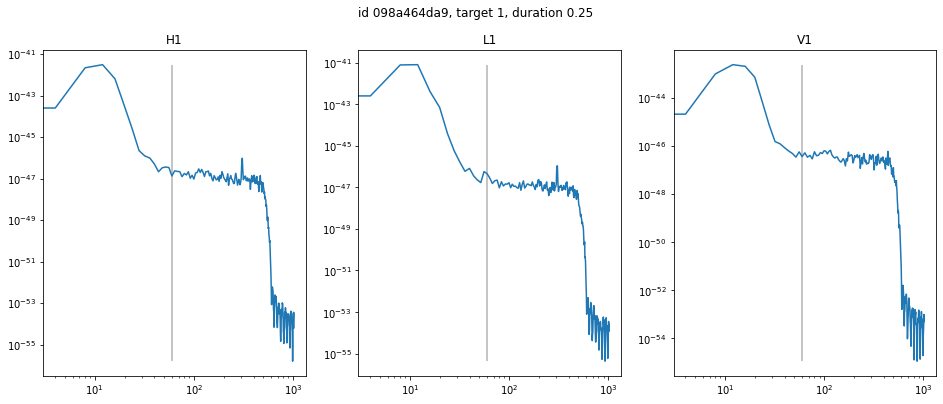

In [ ]:
# Q range
Q_TRANSFORM_old = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
for duration in [0.0625, 0.125, 0.2, 0.25, 0.3, 0.4, 0.5, 1]:
    psd_param_dict = dict(
        segment_duration=duration,
        window='hann', 
        avg_method='median'
    )
    fig = plt.figure(figsize=(16,6))
    signals = ["H1","L1","V1"]
    for i, ts in enumerate(tss):
        ts = ts.highpass_fir(20, 16)
        ts = ts.lowpass_fir(500, 16)
        ts = ts* signal.windows.tukey(len(ts),alpha=0.1)
        psd = ts.psd(**psd_param_dict)
        plt.subplot(1,3,i+1)
        plt.loglog(psd.sample_frequencies, psd.data)
        plt.vlines(x=60,ymin=min(psd.data), ymax=max(psd.data),alpha=0.3)
        plt.title(signals[i])
    plt.suptitle(f"id {idx}, target {target}, duration {duration}")
    plt.show()



In [ ]:
psd.data.shape

(257,)

In [ ]:
psd.data.itemsize

8

In [ ]:
8*257*3*len(train) / 1024/1024

3294.0673828125

In [ ]:
psd.sample_frequencies.data

array([   0.,    4.,    8.,   12.,   16.,   20.,   24.,   28.,   32.,
         36.,   40.,   44.,   48.,   52.,   56.,   60.,   64.,   68.,
         72.,   76.,   80.,   84.,   88.,   92.,   96.,  100.,  104.,
        108.,  112.,  116.,  120.,  124.,  128.,  132.,  136.,  140.,
        144.,  148.,  152.,  156.,  160.,  164.,  168.,  172.,  176.,
        180.,  184.,  188.,  192.,  196.,  200.,  204.,  208.,  212.,
        216.,  220.,  224.,  228.,  232.,  236.,  240.,  244.,  248.,
        252.,  256.,  260.,  264.,  268.,  272.,  276.,  280.,  284.,
        288.,  292.,  296.,  300.,  304.,  308.,  312.,  316.,  320.,
        324.,  328.,  332.,  336.,  340.,  344.,  348.,  352.,  356.,
        360.,  364.,  368.,  372.,  376.,  380.,  384.,  388.,  392.,
        396.,  400.,  404.,  408.,  412.,  416.,  420.,  424.,  428.,
        432.,  436.,  440.,  444.,  448.,  452.,  456.,  460.,  464.,
        468.,  472.,  476.,  480.,  484.,  488.,  492.,  496.,  500.,
        504.,  508.,

In [ ]:

Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=64)
def whiten_custom(ts):
    # ts is pycbc.TimeSeries data type
    # large window
    ts = ts* signal.windows.tukey(len(ts),alpha=0.1)
    # bp before whitening
    ts = ts.highpass_fir(20, 16)
    ts = ts.lowpass_fir(950, 16)
    # whitening
    whiten_strain = ts.whiten(.25, .25, remove_corrupted=True).data.astype("float32")
    # no pad
    whiten_strain_torch = torch.from_numpy(whiten_strain)
    # Q trans
    power = Q_TRANSFORM(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power 

In [ ]:
ts = ts.highpass_fir(highpass_freq, order)
ts = ts.lowpass_fir(lowpass_freq, order)
seg_stride = int(seg_len  *  stride_ratio)
estimated_psd = interpolate(welch(ts,
                                  seg_len=seg_len,
                                  seg_stride=seg_stride), ts.delta_f)  

### Pycbc

In [ ]:
PREPROCESS_DICT = dict(
      segment_duration = .25,
      max_filter_duration= .25,
      highpass_freq=20,
      highpass_order=16,
      lowpass_freq=128*6,
      lowpass_order=16,
      delta_t=2/64,
      logfsteps=64,
      qrange=(8,8) # or (32,32)
)

def preprocess_pipe(strain, 
                    segment_duration = 0.25,
                    max_filter_duration=0.25,
                    highpass_freq=30,
                    highpass_order=64,
                    lowpass_freq=250,
                    lowpass_order=64,
                    delta_t=.01,
                    logfsteps=100,
                    qrange=(8,8),
                    verbose=True,
                    generate_bpsd = True,
                    generate_spectrogram = True
                    ):
    frange = (highpass_freq,lowpass_freq)
    d = {}
    whiten = strain.whiten(segment_duration, max_filter_duration)
    d["whiten"] = whiten
    if generate_bpsd:
        bpsd = whiten.highpass_fir(highpass_freq, highpass_order)\
                    .lowpass_fir(lowpass_freq, lowpass_order)
        d["bpsd"] = bpsd
        if verbose:
            print("bpsd.shape ",bpsd.shape)
    if generate_spectrogram:
        times, freqs, power = whiten.qtransform(delta_t, 
                                                logfsteps=logfsteps,
                                                qrange=qrange,
                                                frange=frange)
        d["times"] = times
        d["freqs"] = freqs
        d["power"] = power
        if verbose:
            print("power.shape ",power.shape)

    return d

In [ ]:
def plot_output_combined(waves, title=None, preprocess_dict=PREPROCESS_DICT.copy()):
    fig = plt.figure(figsize=(24,4))
    for i in range(len(waves)*2):
        plt.subplot(1,6, i + 1)
        strain  = waves[i//2]
        if i % 2 == 0:
            if i < 4:
                preprocess_dict["qrange"] = (8,8)
                preprocess_dict['max_filter_duration'] = 0.25
                preprocess_dict['segment_duration'] = 0.25            
                plt.title(signal_names[i//2] + " qrange(8,8), .25")
            else:
                preprocess_dict["qrange"] = (8,8) 
                preprocess_dict['max_filter_duration'] = 0.35
                preprocess_dict['segment_duration'] = 0.35       
                plt.title(signal_names[i//2] + f" qrange(8,8), .35")
        else:
            if i < 4:
                preprocess_dict["qrange"] = (32,32) 
                preprocess_dict['max_filter_duration'] = 0.25
                preprocess_dict['segment_duration'] = 0.25            
                plt.title(signal_names[i//2] + f" qrange(32,32), .25")
            else:
                preprocess_dict["qrange"] = (32,32) 
                preprocess_dict['max_filter_duration'] = 0.35
                preprocess_dict['segment_duration'] = 0.35       
                plt.title(signal_names[i//2] + f" qrange(32,32), .35")

        d = preprocess_pipe(strain, **preprocess_dict, verbose=False, generate_bpsd=False)
        plt.pcolormesh(d['times'], d['freqs'], d['power']**0.5)
        plt.yscale('log')
    if title is not None:
        plt.suptitle(title)  

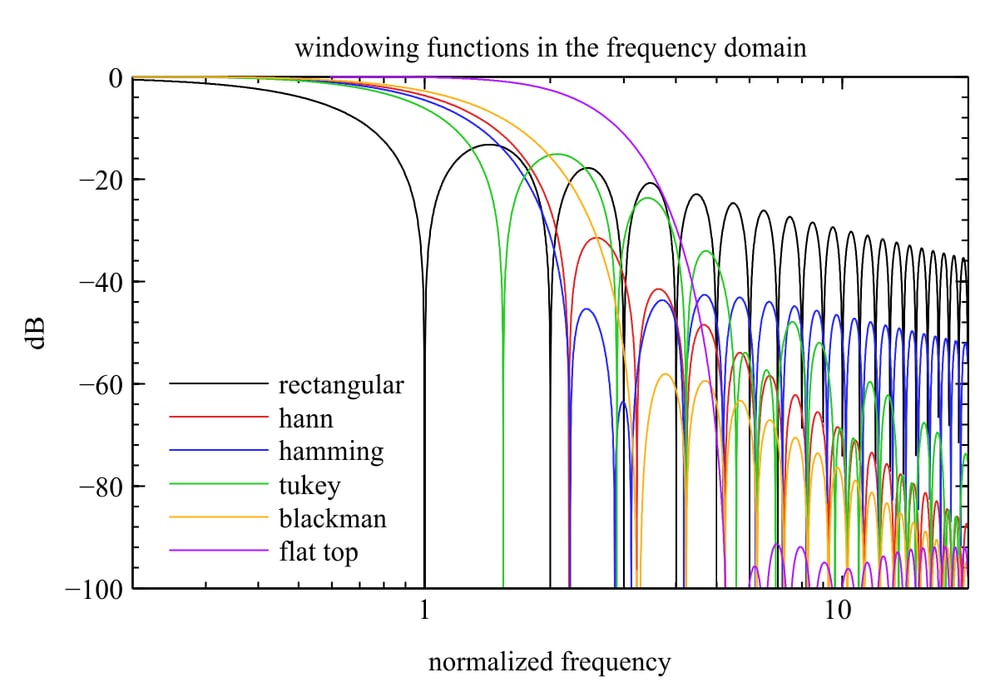

## Initialization

In [ ]:
Q_TRANSFORM_1 = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32, bins_per_octave=24)
pycwt = CWT(fmin=20, fmax=128*7)
Q_TRANSFORM_old = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
#Q_TRANSFORM_old = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=32, bins_per_octave=24, pad_mode= 'reflect', window='hann',center=True) # cannot use tukey
# Q_TRANSFORM_3 = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=32, bins_per_octave=24, pad_mode= 'reflect', window='hann',center=True)
# Q_TRANSFORM_4 = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=32, bins_per_octave=24, pad_mode= 'reflect', window='hann',center=True)
# Q_TRANSFORM_5 = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=32, bins_per_octave=24, pad_mode= 'reflect', window='hann',center=True)

CQT kernels created, time used = 0.0798 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


NameError: ignored

## Custom Whitening

In [ ]:
signal_names=("H1", "L1", "V1")
def get_title(sample_size,lowpass_freq,highpass_freq,seg_len,stride_ratio,tukey_alpha, order):
    return "ss {},lf {}, hf {}, order{}, sl {}, sr{}, ta {}, ".format(sample_size, 
                                                                   lowpass_freq, 
                                                                   highpass_freq, 
                                                                   order, 
                                                                   seg_len, 
                                                                   stride_ratio, 
                                                                   tukey_alpha)

def get_psd(wave, highpass_freq=20, lowpass_freq=950, order=8, seg_len=2048, stride_ratio=.5):
    ts = pycbc.types.TimeSeries(wave, epoch=0, delta_t=1.0/2048)
    ts = ts.highpass_fir(highpass_freq, order)
    ts = ts.lowpass_fir(lowpass_freq, order)
    seg_stride = int(seg_len  *  stride_ratio)
    estimated_psd = interpolate(welch(ts,
                                      seg_len=seg_len,
                                      seg_stride=seg_stride), ts.delta_f)  
    return estimated_psd



def get_psds(sample_size, lowpass_freq, highpass_freq, seg_len, stride_ratio, tukey_alpha, order):
    psds = [[],[],[]]
    avg_psd =[]
    random.seed(42)
    for i in random.sample(train.index.tolist(), sample_size,):
        file_path = train.iloc[i]["file_path"]
        target = train.iloc[i]["target"]
        waves = np.load(file_path).astype(np.float32)
        for site in range(3):
            wave = waves[site]
            estimated_psd = get_psd(wave, highpass_freq, lowpass_freq, order, seg_len, stride_ratio)
            psds[site].append(estimated_psd)
    return psds

Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=128*7, hop_length=64)
def whiten_custom(ts):
    # ts is pycbc.TimeSeries data type
    # large window
    ts = ts* signal.windows.tukey(len(ts),alpha=0.1)
    # bp before whitening
    ts = ts.highpass_fir(20, 16)
    ts = ts.lowpass_fir(950, 16)
    # whitening
    whiten_strain = ts.whiten(.25, .25, remove_corrupted=True).data.astype("float32")
    # no pad
    whiten_strain_torch = torch.from_numpy(whiten_strain)
    # Q trans
    power = Q_TRANSFORM(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power    

def whiten_custom_with_corrupted(ts):
    # ts is pycbc.TimeSeries data type
    # large window
    ts = ts* signal.windows.tukey(len(ts),alpha=0.1)
    # bp before whitening
    ts = ts.highpass_fir(20, 16)
    ts = ts.lowpass_fir(950, 16)
    # whitening
    whiten_strain = ts.whiten(.25, .25, remove_corrupted=False).data.astype("float32")
    # no pad
    whiten_strain_torch = torch.from_numpy(whiten_strain)
    # Q trans
    power = Q_TRANSFORM(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power 

Q_TRANSFORM_old = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
def whiten_custom_old(ts, avg_asd, highpass_freq, lowpass_freq, order, **kwargs):
    ts = ts.highpass_fir(highpass_freq, order)
    ts = ts.lowpass_fir(lowpass_freq, order)
    windowed_ts = ts* signal.windows.tukey(len(ts),alpha=0.2)
    whiten_strain = (windowed_ts.to_frequencyseries() / avg_asd).to_timeseries()
    whiten_strain = np.pad(whiten_strain, (order * 2,  order * 2), 'constant')#to remain 4096 length


    whiten_strain_torch = torch.from_numpy(whiten_strain.data/np.max(whiten_strain.data)).to(torch.float)
    power = Q_TRANSFORM_old(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power


def whiten_custom_1(ts, avg_asd, highpass_freq, lowpass_freq, order, **kwargs):
    windowed_ts = ts* signal.windows.tukey(len(ts),alpha=.2)
    ts = windowed_ts.highpass_fir(highpass_freq, 16)
    ts = windowed_ts.lowpass_fir(lowpass_freq, 16)
    #whiten_strain = (windowed_ts.to_frequencyseries() / avg_asd).to_timeseries()
    #whiten_strain = np.pad(whiten_strain, (order * 2,  order * 2), 'constant')#to remain 4096 length
    whiten_strain = ts.whiten(.25, .25)
    #pad_num = (4096 - len(whiten_strain)) // 2
    #whiten_strain = np.pad(whiten_strain, (pad_num,  pad_num), 'constant')#to remain 4096 length

    whiten_strain_torch = torch.from_numpy(whiten_strain.data).to(torch.float)
    power = Q_TRANSFORM_old(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power


def whiten_custom_2(ts, avg_asd, highpass_freq, lowpass_freq, order, **kwargs):
    #windowed_ts = ts* signal.windows.tukey(len(ts),alpha=.2)
    ts = ts.highpass_fir(highpass_freq, 16)
    ts = ts.lowpass_fir(lowpass_freq, 16)
    #whiten_strain = (windowed_ts.to_frequencyseries() / avg_asd).to_timeseries()
    #whiten_strain = np.pad(whiten_strain, (order * 2,  order * 2), 'constant')#to remain 4096 length
    whiten_strain = ts.whiten(.25, .25)
    #pad_num = (4096 - len(whiten_strain)) // 2
    #whiten_strain = np.pad(whiten_strain, (pad_num,  pad_num), 'constant')#to remain 4096 length

    whiten_strain_torch = torch.from_numpy(whiten_strain.data).to(torch.float)
    power = Q_TRANSFORM_old(whiten_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return whiten_strain, power

def plot_psds(avg_psd, std_psd, title):
    plt.figure(figsize=(18, 6))

    plt.subplot(1,3,1)
    plt.errorbar(estimated_psd.sample_frequencies.data, avg_psd[0], yerr=std_psd[0],lolims=True, ecolor='r',elinewidth=.1)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(10e-53, 10e-40)
    plt.title(signal_names[0],size=15)

    plt.subplot(1,3,2)
    plt.errorbar(estimated_psd.sample_frequencies.data, avg_psd[1], yerr=std_psd[1],lolims=True, ecolor='r',elinewidth=.1)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(10e-53, 10e-40)
    plt.title(signal_names[1],size=15)

    plt.subplot(1,3,3)
    plt.errorbar(estimated_psd.sample_frequencies.data, avg_psd[2], yerr=std_psd[2],lolims=True, ecolor='r',elinewidth=.1)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(10e-53, 10e-40)
    plt.title(signal_names[2],size=15)
    plt.suptitle(title, size=16)
    plt.show()

CQT kernels created, time used = 0.0152 seconds
CQT kernels created, time used = 0.0136 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [ ]:
psds_dict = dict(
    sample_size = 500,
    lowpass_freq = 950,
    highpass_freq = 20,
    seg_len = 2048,
    stride_ratio = 0.5,
    tukey_alpha = 0,
    order = 8,
)

In [ ]:
%%time
psds_d = {}
avg_psd_d = {}
for seg_len in [2048]:
    psds_dict['seg_len'] = seg_len
    title = get_title(**psds_dict)
    psds = get_psds(**psds_dict)
    avg_psd = [np.mean(psds[site], axis=0) for site in range(3)]
    std_psd = [np.std(psds[site], axis=0) for site in range(3)]
    psds_d[seg_len] = psds
    avg_psd_d[seg_len] = avg_psd
    #plot_psds(avg_psd, std_psd, title)

CPU times: user 8.43 s, sys: 445 ms, total: 8.88 s
Wall time: 9min 14s


In [ ]:
AVG_ASD = [0,0,0]
for site in range(3):
    AVG_ASD[site] = avg_psd_d[2048][site]  ** 0.5
# !mkdir $OUT_DIR
# np.save(OUT_DIR + 'avg_asd.npy', AVG_ASD)

## Check Real Event Performance

In [ ]:
def preprocess_pipe_2(strain, 
                    segment_duration = 0.25,
                    max_filter_duration = 0.25,
                    highpass_freq=20,
                    highpass_order=16,
                    lowpass_freq=600,
                    lowpass_order=16,                    
                    verbose=True,
                    generate_bpsd = True,
                    generate_spectrogram = True
                    ):
    d = {}
    whiten = strain.whiten(segment_duration, max_filter_duration)
    d["whiten"] = whiten
    if generate_bpsd:
        bpsd = whiten.highpass_fir(highpass_freq, highpass_order)\
                    .lowpass_fir(lowpass_freq, lowpass_order)
        d["bpsd"] = bpsd
        if verbose:
            print("bpsd.shape ",bpsd.shape)
    if generate_spectrogram:
        whiten_strain, power =  whiten_custom(strain)
        d["custom_whiten_strain_1"] = whiten_strain
        d["custom_whiten_power_1"] = power

        whiten_strain, power =  whiten_custom_with_corrupted(strain)
        d["custom_whiten_strain_2"] = whiten_strain
        d["custom_whiten_power_2"] = power

        whiten_strain, power =  whiten_custom_old(strain, AVG_ASD[0], **psds_dict)
        d["custom_whiten_strain_3"] = whiten_strain
        d["custom_whiten_power_3"] = power


        times, freqs, power = whiten.qtransform(delta_t=2/130, 
                                                logfsteps=130,
                                                qrange=(8,8),
                                                frange=(highpass_freq, lowpass_freq))
        d["times_cbc_1"] = times
        d["freqs_cbc_1"] = freqs
        d["power_cbc_1"] = power
        times, freqs, power = whiten.qtransform(delta_t=2/130, 
                                                logfsteps=130,
                                                qrange=(32,32),
                                                frange=(highpass_freq, lowpass_freq))
        d["times_cbc_2"] = times
        d["freqs_cbc_2"] = freqs
        d["power_cbc_2"] = power

        whiten = torch.from_numpy(whiten.data).to(torch.float)
        power = Q_TRANSFORM_1(whiten).squeeze().numpy()
        power = np.flipud(power)
        d["power_1"] = power
        
        out = pycwt(whiten.unsqueeze(0).unsqueeze(0))
        out = out.squeeze().squeeze().numpy()
        d["out"] = out
        if verbose:
            print("power.shape ",power.shape)
    return d

In [ ]:
def plot_output_single(H1, title=None):
    x = 7
    qtransform = Q_TRANSFORM_1
    d = preprocess_pipe_2(H1, verbose=False, generate_bpsd=False)
    fig = plt.figure(figsize=(x * 5,4))

    plt.subplot(1, x, 1)
    plt.plot(d['custom_whiten_strain_1'])
    #plt.imshow(d['custom_whiten_power_1'])
    plt.title("whiten without corrupted")

    plt.subplot(1, x, 2)
    plt.plot(d['custom_whiten_strain_2'])
    #plt.imshow(d['custom_whiten_power_2'])
    plt.title("whiten with corrupted")

    plt.subplot(1, x, 3)
    plt.plot(d['custom_whiten_strain_3'])
    #plt.imshow(d['custom_whiten_power_2'])
    plt.title("whiten old")

    plt.subplot(1, x, 4)
    plt.imshow(d['power_1'])
    plt.title("CQT1992v2")

    plt.subplot(1, x, 5)
    plt.imshow(d['out'], aspect="auto");
    plt.title("CWT")

    plt.subplot(1, x, x-1)
    plt.pcolormesh(d['times_cbc_1'], d['freqs_cbc_1'], d['power_cbc_1']**0.5,shading="auto")
    plt.yscale('log')
    plt.title("pycbc (8,8)")

    plt.subplot(1, x, x)
    plt.pcolormesh(d['times_cbc_2'], d['freqs_cbc_2'], d['power_cbc_2']**0.5,shading="auto")
    plt.yscale('log')
    plt.title("pycbc (32,32)")

    if title is not None:
        plt.suptitle(title)    
    plt.show()
    return d

## Apply to Real Black Hole Merge Events

CQT kernels created, time used = 0.0195 seconds
CQT kernels created, time used = 0.0306 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [237]:
def whiten_custom(ts, hf=15, lf=500, order=4, segment_duration=0.25, q_transform=None, window="tukey", welch_window="hann", alpha=0.2):
    if window=="tukey":
        ts = ts * signal.windows.tukey(len(ts),alpha=alpha)
    elif window == 'hann':
        ts = ts * signal.windows.hann(len(ts))

    ts = ts.highpass_fir(hf, order)
    ts = ts.lowpass_fir(lf, order)

    seg_len = int(segment_duration * ts.sample_rate)
    seg_stride = int(seg_len / 2)
    if welch_window == "hann":
        ww = "hann"
    elif welch_window == "tukey":
        ww = signal.windows.tukey(seg_len, alpha=.5)

    psd = interpolate(welch(ts, seg_len=seg_len, seg_stride=seg_stride, window=ww), 1.0 / ts.duration)
    white_strain = (ts.to_frequencyseries() / psd ** 0.5).to_timeseries()
    white_strain = white_strain.highpass_fir(hf, order)
    white_strain = white_strain.lowpass_fir(lf, order).data.astype("float32")

    white_strain_torch = torch.from_numpy(white_strain)
    power = q_transform(white_strain_torch).squeeze().numpy()
    power = np.flipud(power)
    return white_strain, power  

Q_TRANSFORM_1 = CQT1992v2(sr=2048, fmin=15, fmax=500, hop_length=32, bins_per_octave=12, filter_scale=0.5)
Q_TRANSFORM_2 = CQT1992v2(sr=2048, fmin=15, fmax=500, hop_length=64, bins_per_octave=24, filter_scale=0.5)
q_trans_dict = {
    "fm500_hp32_bpo12_fs.50":Q_TRANSFORM_1,
    "fm500_hp64_bpo24_fs.50":Q_TRANSFORM_2,
}

def img_norm(img):
    # img shape (3, xx , xx)
    local_mean = np.expand_dims(img.reshape(3,-1).mean(axis=1),(1,2))
    local_std = np.expand_dims(img.reshape(3,-1).std(axis=1),(1,2))
    img = (img - local_mean ) / local_std
    img = img.astype("float16")
    return img

CQT kernels created, time used = 0.0158 seconds
CQT kernels created, time used = 0.0313 seconds


/usr/local/lib/python3.7/dist-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [240]:
def plot_single_v2(ts, suptitle="", plot_old=False):
    power_res = {}

    for window in [None,"tukey"]:
          for name, q_trans in q_trans_dict.items():
              white_strain, power = whiten_custom(ts, q_transform=q_trans,window=window)
              power_res[name + f"_{window}"] = power
    # for name, q_trans in q_trans_dict.items():
    #     white_strain, power = whiten_seg30(ts, q_transform=q_trans)
    #     power_res[name + "seg30"] = power
    plt.figure(figsize=(24,4))
    for i, (name,power) in enumerate(power_res.items(),1):
        plt.subplot(1,len(power_res) + int(plot_old),i)
        plt.imshow(power, aspect="auto")
        plt.title(name)
    if plot_old:
        white_strain, power = whiten_custom_old(ts, AVG_ASD[0], **psds_dict)
        plt.subplot(1,len(power_res) + int(plot_old), len(power_res) + int(plot_old))
        plt.imshow(power, aspect="auto")
        plt.title("old method")
    plt.suptitle(suptitle)
    plt.show()
    return power_res

In [241]:
waves_V1 = []
merger_names_V1 = []
for merger_name in catalog.Catalog():
    waves = []
    m = catalog.Merger(merger_name.split("-")[0])
    try:
        H1 = m.strain("H1").time_slice(m.time-1.5, m.time + .5)
        H1 = resample_to_delta_t(H1,1/2048)
        waves.append(H1)

        L1 = m.strain("L1").time_slice(m.time-1.5, m.time+.5)
        L1 = resample_to_delta_t(L1,1/2048)
        waves.append(L1)

        V1 = m.strain("V1").time_slice(m.time-1.5, m.time+.5)
        V1 = resample_to_delta_t(V1,1/2048)
        waves.append(V1)
    except:
        pass

    if len(waves) == 3:
        waves_V1.append(waves[-1])
        merger_names_V1.append(merger_name)

    power_res = plot_single_v2(H1, suptitle=merger_name)
    #plot_output_combined(waves, title=merger_name, preprocess_dict=PREPROCESS_DICT.copy())
    #d = plot_output_single(H1, title=merger_name)

Output hidden; open in https://colab.research.google.com to view.

## Apply to Competition Image

In [ ]:
def plot_output_combined_custom(waves, title=None, old_powers=None):
    if old_powers is not None:
        fig = plt.figure(figsize=(18 + len(old_powers) * 6,4))
    else:
        fig = plt.figure(figsize=(18,4))
    for i in range(len(waves)):
        plt.subplot(1,3 + len(old_powers), i + 1)
        strain  = waves[i]
        plt.title(signal_names[i])
        whiten_strain, power = whiten_custom(waves[i])
        plt.imshow(power)
    for i in range(len(old_powers)):
        plt.subplot(1,3 + len(old_powers), i + len(waves) + 1)
        power  = old_powers[i]
        power = np.flipud(power)
        plt.title(signal_names[i] + " old")
        plt.imshow(power)
    if title is not None:
        plt.suptitle(title)  

In [ ]:
def read_waves(file):
    waves = np.load(file)
    waves_cbc = []
    for i in range(3):
      waves_cbc.append(pycbc.types.TimeSeries(waves[i], epoch=0, delta_t=1.0/2048))
    return waves_cbc

def get_title(file):
    idx = file.split("/")[-1].split(".")[0]
    target = train.query(f"id == '{idx}'")["target"].iloc[0]
    pred = train.query(f"id == '{idx}'")["preds"].iloc[0]
    #plot_waves(waves_cbc, idx, target, pred)
    title="{}, L1, Target {} ({:.0%})".format(idx, target, pred)
    return title

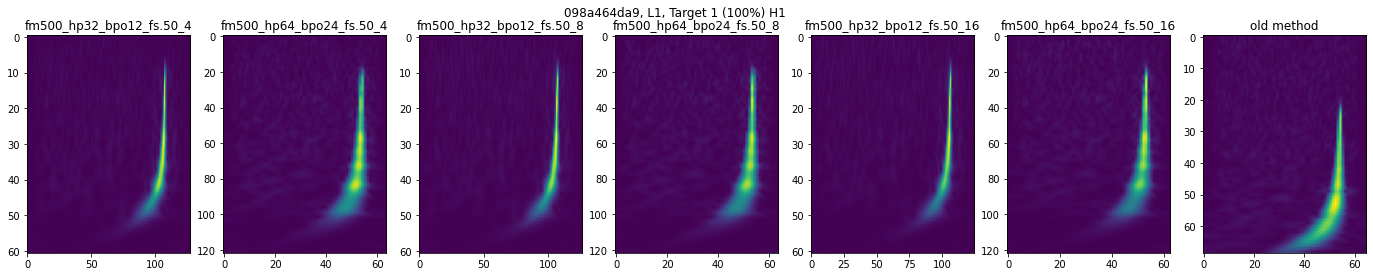

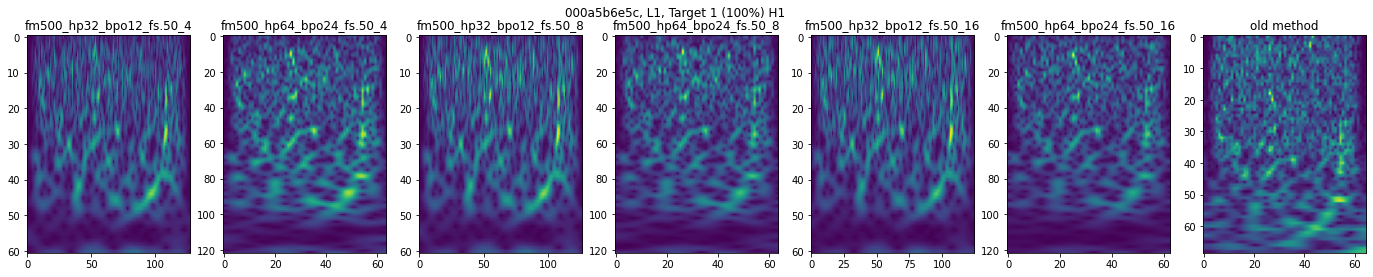

In [ ]:
for idx in ['098a464da9','000a5b6e5c' ]:
    obvious_file = train.query(f"id == '{idx}'")["file_path"].iloc[0] 
    #old_powers_file = train.query(f"id == '{idx}'")["old_q_tran"].iloc[0]
    #old_powers = np.load(old_powers_file)
    waves_cbc = read_waves(obvious_file)
    title = get_title(obvious_file)
    plot_single_v2(waves_cbc[0],suptitle=title + " H1", plot_old=True)
    # d=plot_output_single(waves_cbc[0], title=title)
    # plot_output_combined_custom(waves_cbc, title, old_powers)

In [ ]:
idxes_sample = []
valid = train.query("fold==0").copy()
preds_dict = {}
print("Total: {}".format(len(valid)))
preds_dict['easy_preds_1'] = valid.query("target == 1 and preds >= 1")["file_path"].values
preds_dict['easy_preds_0'] = valid.query("target == 0 and preds < 0.05")["file_path"].values
preds_dict['hard_preds_1'] = valid.query("target == 1 and preds < 0.05")["file_path"].values
preds_dict['hard_preds_0'] = valid.query("target == 0 and preds >= 0.999")["file_path"].values
for key, vals in preds_dict.items():
    print(key,":", len(vals))
    idxes_sample.extend([val.split("/")[-1].split(".")[0] for val in vals[:2]])

Total: 112000
easy_preds_1 : 114
easy_preds_0 : 58
hard_preds_1 : 9
hard_preds_0 : 11


In [ ]:
len(idxes_sample)

8

In [ ]:
for idx in idxes_sample:
    obvious_file = train.query(f"id == '{idx}'")["file_path"].iloc[0] 
    #old_powers_file = train.query(f"id == '{idx}'")["old_q_tran"].iloc[0]
    #old_powers = np.load(old_powers_file)
    waves_cbc = read_waves(obvious_file)
    title = get_title(obvious_file)
    plot_single_v2(waves_cbc[0],suptitle=title + " H1", plot_old=True)
    # d=plot_output_single(waves_cbc[0], title=title)
    # plot_output_combined_custom(waves_cbc, title, old_powers)

Output hidden; open in https://colab.research.google.com to view.

### Easy 1

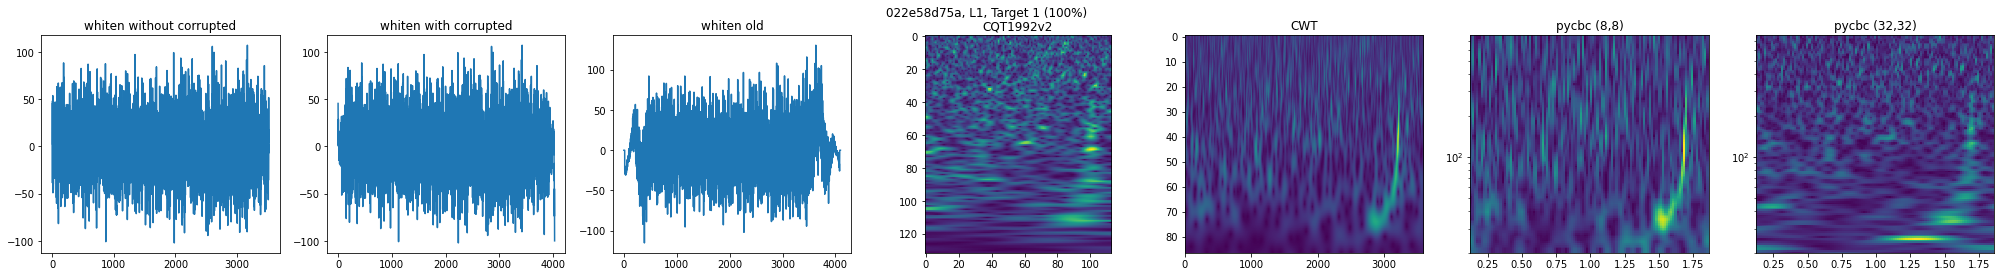

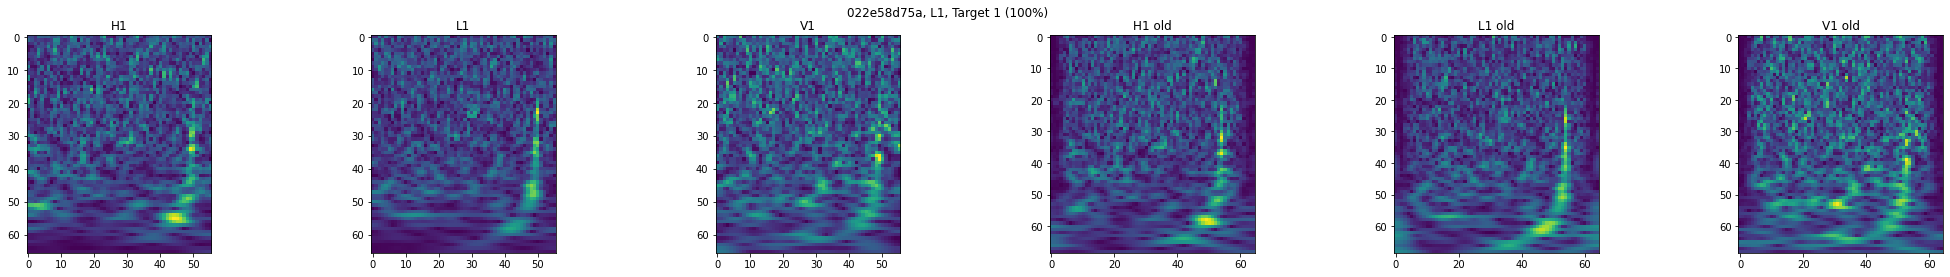

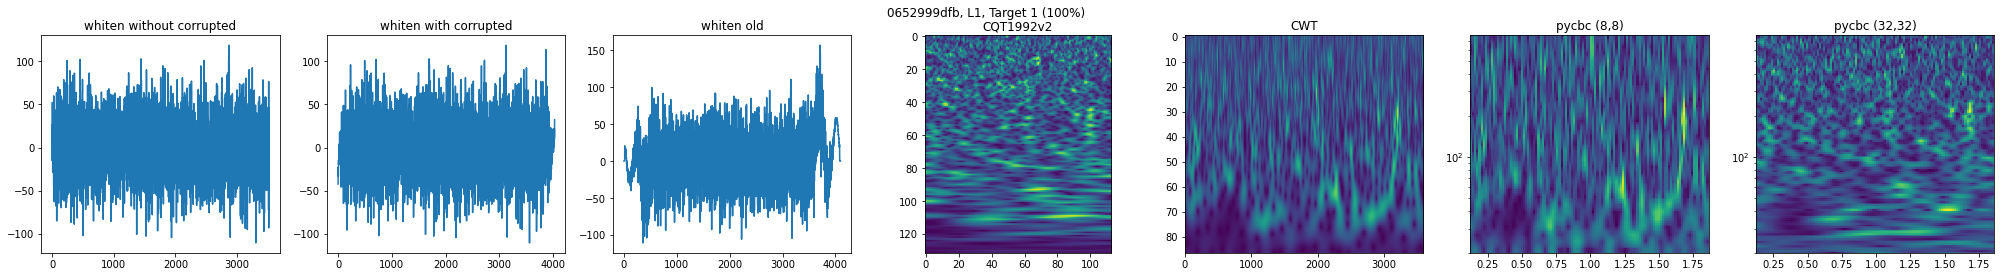

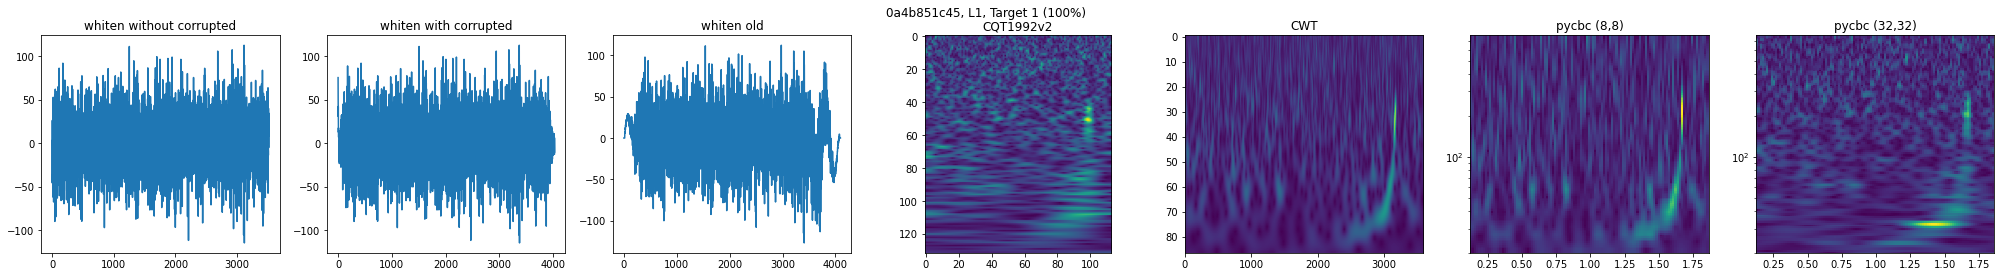

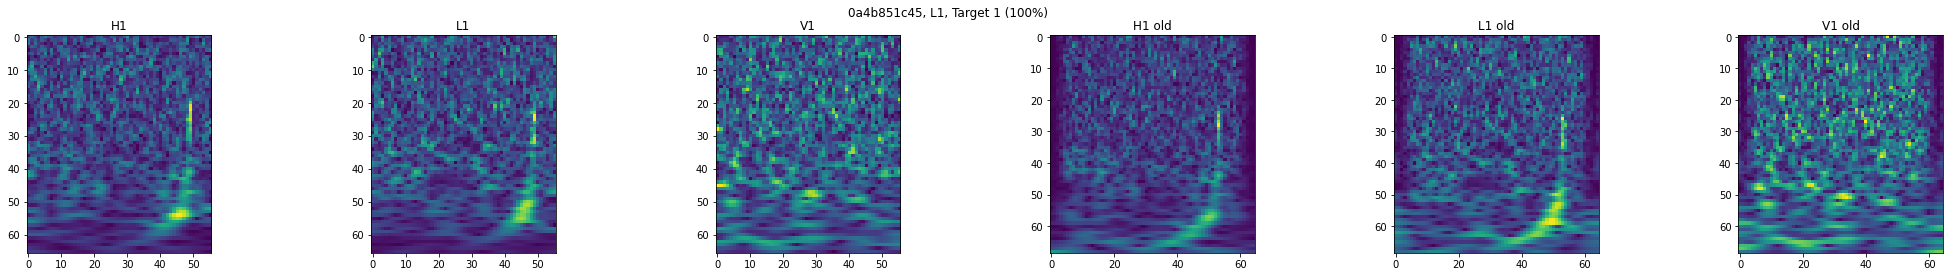

In [ ]:
for i, file in enumerate(preds_dict["easy_preds_1"], 0):
    if i == 3:
        break
    
    #whiten_strain, power = whiten_custom(waves_cbc[0], AVG_ASD[0], **psds_dict)
    waves_cbc = read_waves(file)
    old_powers_file = "./input/q-train/" + file.split("/")[-1]
    old_powers = np.load(old_powers_file)

    title = get_title(file)
    #plot_output_combined(waves_cbc, title, PREPROCESS_DICT.copy())        
    d = plot_output_single(waves_cbc[0], title=title)
    plot_output_combined_custom(waves_cbc, title, old_powers)

### Easy 0

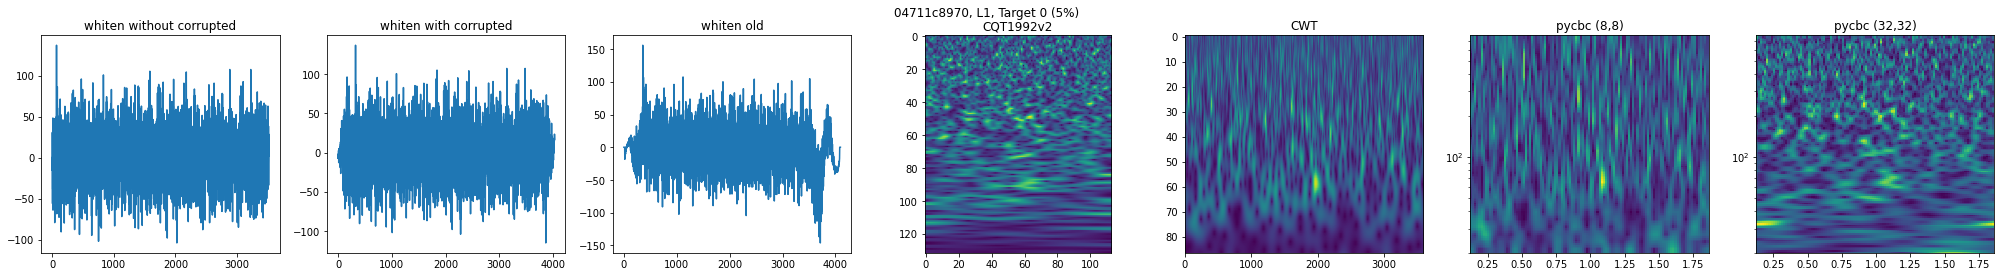

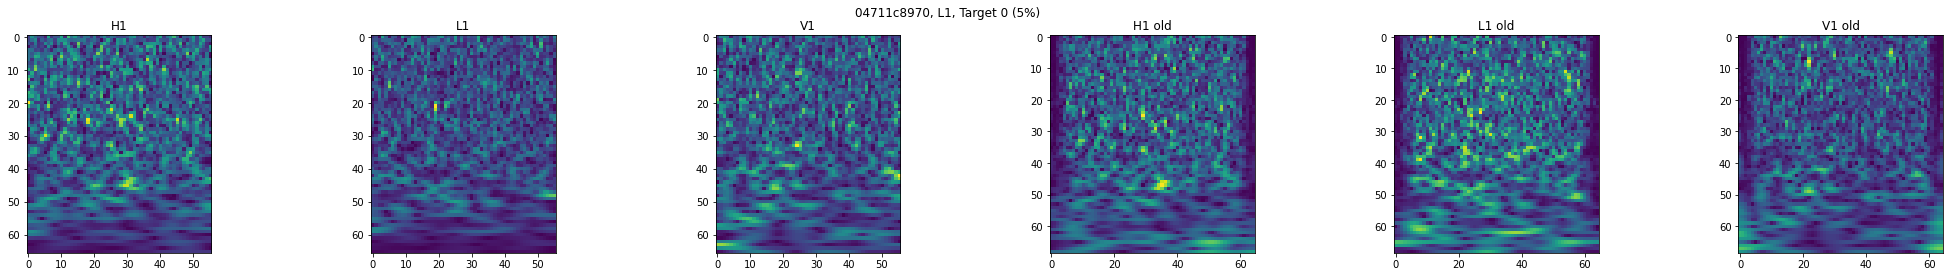

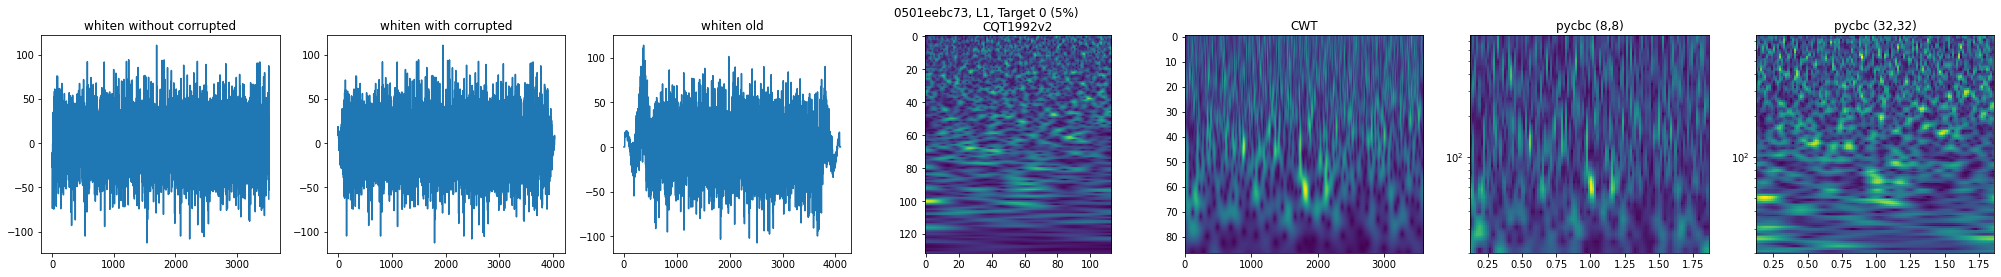

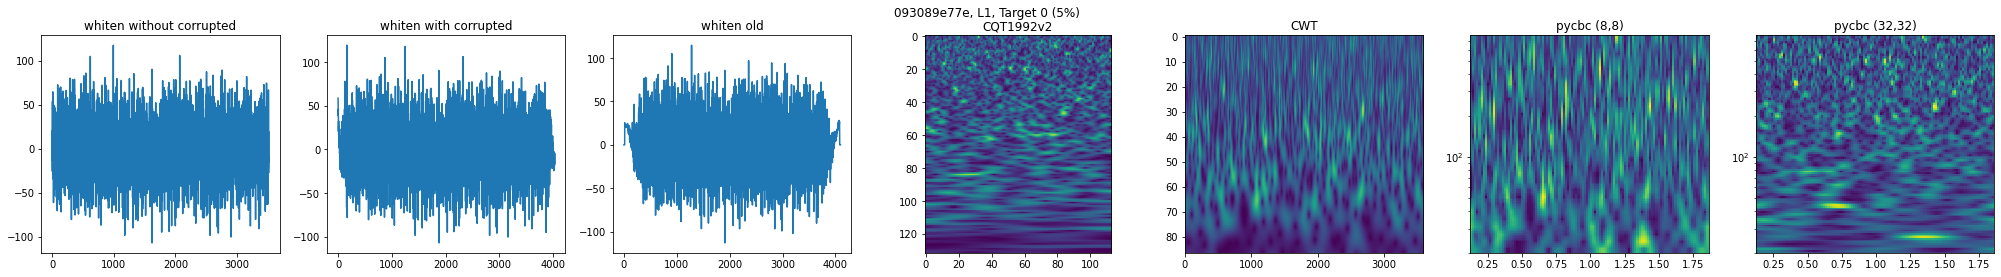

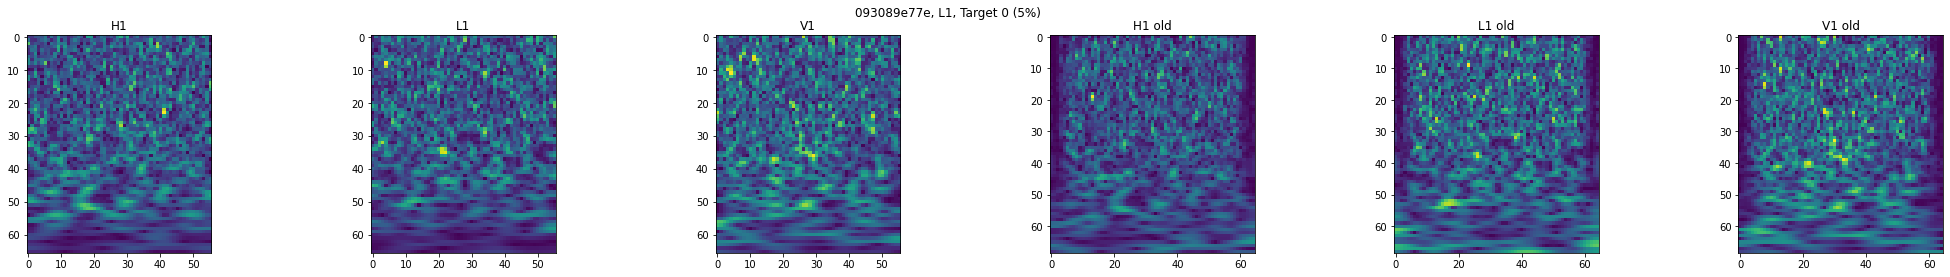

In [ ]:
for i, file in enumerate(preds_dict["easy_preds_0"], 0):
    if i == 3:
        break
    waves_cbc = read_waves(file)
    title = get_title(file)
    old_powers_file = "./input/q-train/" + file.split("/")[-1]
    old_powers = np.load(old_powers_file)

    title = get_title(file)
    #plot_output_combined(waves_cbc, title, PREPROCESS_DICT.copy())        
    d = plot_output_single(waves_cbc[0], title=title)
    plot_output_combined_custom(waves_cbc, title, old_powers)


### Hard 1

In [ ]:
for i, file in enumerate(preds_dict["hard_preds_1"], 0):
    if i == 5:
        break
    waves_cbc = read_waves(file)
    title = get_title(file)
    old_powers_file = "./input/q-train/" + file.split("/")[-1]
    old_powers = np.load(old_powers_file)

    title = get_title(file)
    #plot_output_combined(waves_cbc, title, PREPROCESS_DICT.copy())        
    d = plot_output_single(waves_cbc[0], title=title)
    plot_output_combined_custom(waves_cbc, title, old_powers)

### Hard 0

In [ ]:
for i, file in enumerate(preds_dict["hard_preds_0"], 0):
    if i == 5:
        break
    waves_cbc = read_waves(file)
    title = get_title(file)
    old_powers_file = "./input/q-train/" + file.split("/")[-1]
    old_powers = np.load(old_powers_file)

    title = get_title(file)
    #plot_output_combined(waves_cbc, title, PREPROCESS_DICT.copy())        
    d = plot_output_single(waves_cbc[0], title=title)
    plot_output_combined_custom(waves_cbc, title, old_powers)

## Save One Image 

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt


In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas   

def save_plot(d, path, width=8, height=8, dpi=22):
    fig = plt.figure(figsize=(width, height),dpi=dpi,frameon=False)   
    ax = fig.add_axes([0., 0., 1., 1.]) 
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()    
    fig.add_axes(ax)
    ax.pcolormesh(d['times'], d['freqs'], d['power']**0.5)
    ax.set_yscale('log')
    plt.savefig(path)
    plt.close()


def get_plot(strain, dir, name, preprocess_dict=PREPROCESS_DICT.copy(), width=8, height=8, dpi=22):
    #fig = plt.figure(figsize=(8,8))
    if name != "V1":
        preprocess_dict['max_filter_duration'] = 0.25
        preprocess_dict['segment_duration'] = 0.25            
    else:
        preprocess_dict['max_filter_duration'] = 0.35
        preprocess_dict['segment_duration'] = 0.35       
    
    path = dir + name + "-8-8.jpg"
    preprocess_dict["qrange"] = (8,8)
    d = preprocess_pipe(strain, **preprocess_dict, verbose=False, generate_bpsd=False)
    save_plot(d, path, width, height, dpi)

    path = dir + name + "-32-32.jpg"
    preprocess_dict["qrange"] = (32,32)
    d = preprocess_pipe(strain, **preprocess_dict, verbose=False, generate_bpsd=False)
    save_plot(d, path, width, height, dpi)
    return



In [ ]:
width = 3
height = 3
dpi = 56

In [ ]:
import multiprocessing

In [ ]:
!echo "Threads/core: $(nproc --all)"

Threads/core: 2


In [ ]:
idx = '098a464da9'
dir = "./train_image/" + idx + "/"
if not os.path.exists(dir):
    os.makedirs(dir)
obvious_file = train.query(f"id == '{idx}'")["file_path"].iloc[0]
waves_cbc = read_waves(obvious_file)
for i in range(3):
    get_plot(waves_cbc[i], dir, name=signal_names[i], preprocess_dict=PREPROCESS_DICT.copy(), width=width, height=height, dpi=dpi)

In [ ]:
!du -sh /content/train_image/098a464da9

52K	/content/train_image/098a464da9


In [ ]:
52 * 786000 / 1024 / 1024

38.97857666015625

In [ ]:
image = Image.open('/content/train_image/098a464da9/H1-8-8.jpg')
print(image.format)
print(image.size)
print(image.mode)

JPEG
(168, 168)
RGB


In [ ]:
from numpy import asarray
data = asarray(image)
data.shape

(168, 168, 3)

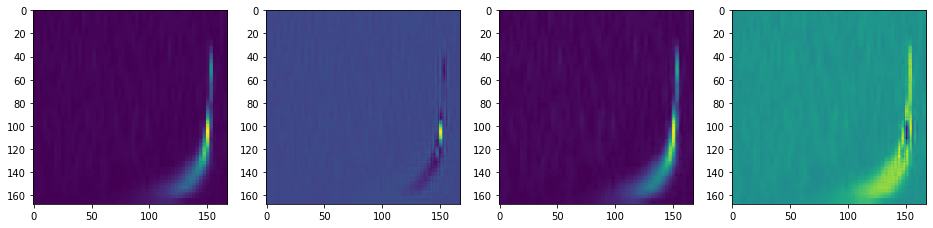

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.imshow(data)
plt.subplot(1,4,2)
plt.imshow(data[:,:,0])
plt.subplot(1,4,3)
plt.imshow(data[:,:,1])
plt.subplot(1,4,4)
plt.imshow(data[:,:,2])

## Save All Image

In [ ]:
%%time

def get_train(i, file_paths=train["file_path"].values):
    file = file_paths[i]
    idx = file.split("/")[-1].split(".")[0]
    dir = "./train_image/" + idx + "/"
    if not os.path.exists(dir):
        os.makedirs(dir)
    waves_cbc = read_waves(file)
    for i in range(3):
        get_plot(waves_cbc[i], dir, name=signal_names[i], preprocess_dict=PREPROCESS_DICT.copy(), width=width, height=height, dpi=dpi)
    return

with multiprocessing.Pool(2) as p:
    p.map(get_train, range(100))

CPU times: user 62.8 ms, sys: 60.6 ms, total: 123 ms
Wall time: 5.42 s


In [ ]:
5.21 / 10 * 786000 / 60 / 60

113.75166666666668

In [ ]:
%%time
def get_test(i, file_paths=test["file_path"].values):
    file = file_paths[i]
    idx = file.split("/")[-1].split(".")[0]
    dir = "./test_image/" + idx + "/"
    if not os.path.exists(dir):
        os.makedirs(dir)
    waves_cbc = read_waves(file)
    for i in range(3):
        get_plot(waves_cbc[i], dir, name=signal_names[i], preprocess_dict=PREPROCESS_DICT.copy(), width=width, height=height, dpi=dpi)
    return

with multiprocessing.Pool(2) as p:
    p.map(get_test, range(100))

KeyboardInterrupt: ignored

In [ ]:
!pip install line_profiler


     |████████████████████████████████| 63 kB 1.8 MB/s 


In [ ]:
import line_profiler
%load_ext line_profiler

In [ ]:
%lprun -f get_plot get_test(1) #-> train_loader most time, Trainer.train_epoch, DataRetriever.__getitem__

In [ ]:
%lprun -f save_plot get_test(1) #-> train_loader most time, Trainer.train_epoch, DataRetriever.__getitem__

In [ ]:
58.1 / 100 * 786000 / 60 / 60

126.85166666666666

In [ ]:
!du -shc /content/train_image/*

112K	/content/train_image/00000e74ad
108K	/content/train_image/00001f4945
112K	/content/train_image/0000661522
112K	/content/train_image/00007a006a
112K	/content/train_image/0000a38978
104K	/content/train_image/0000bb9f3e
112K	/content/train_image/0000c3b9c9
108K	/content/train_image/0000d61b7b
112K	/content/train_image/0001016d12
112K	/content/train_image/00010beb4a
4.0K	/content/train_image/000118b40d
52K	/content/train_image/098a464da9
1.2M	total


In [ ]:
!du -shc /content/test_image/*

112K	/content/test_image/00005bced6
108K	/content/test_image/0000806717
108K	/content/test_image/0000ef4fe1
108K	/content/test_image/00020de251
112K	/content/test_image/00024887b5
108K	/content/test_image/0002b00931
112K	/content/test_image/0003259f74
108K	/content/test_image/000532d9b1
112K	/content/test_image/00053de60c
108K	/content/test_image/00055a3ff5
148K	/content/test_image/00057291a8
1.3M	total


In [ ]:
112 * 786000 / 1024 / 1024

83.953857421875